# `rail.creation` demo: fit a p(z, data) model

_Alex Malz (GCCL@RUB)_ & _Bryce Kalmbach (UW)_

Stolen wholesale from [the XDGMM demo](https://github.com/tholoien/XDGMM/blob/master/Notebooks/Demo.ipynb).

In [1]:
import sys
sys.path.append('../../../pam/')
from pam import gan as pamGAN
from pam import defaultDiscriminator, defaultGenerator
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import corner

import os
from astropy.io import fits

## Read in simulated data

Expensive to make but includes complex physical effects

In [3]:
hdulist = fits.open('/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC1/simulation_catalogs/buzzard_base/Final_Buzzard_training_file.fits')

In [4]:
data_df = pd.DataFrame(hdulist[1].data)

In [5]:
data_df.head()

,BuzzID,oldID,ecatID,ra,dec,redshift,mstar,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,4,1868,265694,63.197601,-41.453098,0.038356,2.692900e+09,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,14,25650,215939,63.153801,-40.588200,0.058309,1.315350e+10,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,18,30908,494449,63.624401,-42.628899,0.063701,4.831440e+07,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,21,34983,159487,63.646999,-42.124901,0.059006,2.670790e+08,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,22,36218,273518,63.472801,-42.423302,0.063202,4.825270e+07,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


In [6]:
# To get rid of byte order issue:
# (See https://pandas.pydata.org/pandas-docs/version/0.19.1/gotchas.html#byte-ordering-issues)

for column_name in data_df.columns:
    data_df[column_name] = data_df[column_name].values.byteswap().newbyteorder()

In [7]:
print(data_df.columns)

Index(['BuzzID', 'oldID', 'ecatID', 'ra', 'dec', 'redshift', 'mstar', 'LSSTu',
       'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy', 'errLSSTu', 'errLSSTg',
       'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy'],
      dtype='object')


## Clean up data and prepare training catalog

From our scatter plot we can see that missing data is recorded as 99. Let's only take values where we have all the magnitudes for the galaxy.

Text(0, 0.5, 'LSSTg')

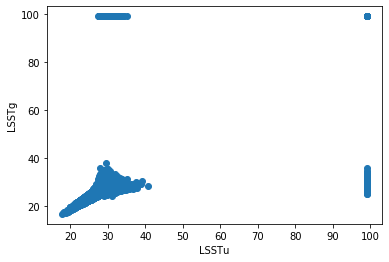

In [8]:
plt.scatter(data_df['LSSTu'], data_df['LSSTg'])
plt.xlabel('LSSTu')
plt.ylabel('LSSTg')

In [9]:
clean_data_df = data_df.query('%s < 90. and %s < 90. and %s < 90. and %s < 90. and %s < 90. and %s < 90.' % ('LSSTu',
                                                                                                             'LSSTg',
                                                                                                             'LSSTr',
                                                                                                             'LSSTi',
                                                                                                             'LSSTz',
                                                                                                             'LSSTy'))

In [10]:
clean_data_df = clean_data_df.reset_index(drop=True)

In [11]:
clean_data_df.head()

,BuzzID,oldID,ecatID,ra,dec,redshift,mstar,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,4,1868,265694,63.197601,-41.453098,0.038356,2.692900e+09,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,14,25650,215939,63.153801,-40.588200,0.058309,1.315350e+10,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,18,30908,494449,63.624401,-42.628899,0.063701,4.831440e+07,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,21,34983,159487,63.646999,-42.124901,0.059006,2.670790e+08,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,22,36218,273518,63.472801,-42.423302,0.063202,4.825270e+07,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


Create a training dataset only consisting of photometric information and redshift.

In [12]:
train_df = clean_data_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']]

In [13]:
train_df.head()

,redshift,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,0.038356,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,0.058309,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,0.063701,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,0.059006,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,0.063202,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


Try log of errors

In [25]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    train_df['errLSST%s' % band] = np.log10(train_df['errLSST%s' % band])

<ipython-input-25-bea1505758d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['errLSST%s' % band] = np.log10(train_df['errLSST%s' % band])


In [26]:
train_df.head()

,redshift,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,0.038356,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,-2.301030,-2.30103,-2.30103,-2.30103,-2.301030,-2.301030
1,0.058309,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,-2.292430,-2.30103,-2.30103,-2.30103,-2.301030,-2.301030
2,0.063701,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,-2.167491,-2.29243,-2.30103,-2.29243,-2.283997,-2.193820
3,0.059006,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,-2.259637,-2.30103,-2.30103,-2.30103,-2.301030,-2.292430
4,0.063202,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,-2.214670,-2.29243,-2.30103,-2.29243,-2.283997,-2.200659


## Augment simulated data

To densely populate data space

Train GAN

In [27]:
pz_gan = pamGAN(seed=17)

In [28]:
data_dim_size = 13
hidden_dim_size = 64
disc = defaultDiscriminator(data_dim_size, hidden_dim_size)
gen = defaultGenerator(data_dim_size, hidden_dim_size)

In [29]:
pz_gan.set_training_models(disc, gen)

We can print out the architectures of the discriminator and generator to see what they look like. If we want to use different architectures then we only need to build them using pytorch and set them using `set_training_models` like we did in the last step above.

In [30]:
print(disc)

defaultDiscriminator(
  (d): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=1, bias=True)
    (8): Sigmoid()
  )
)


In [31]:
print(gen)

defaultGenerator(
  (g): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=13, bias=True)
  )
)


In [32]:
%%time
n_epochs = 1000
pz_gan.train_gan(train_df.values, n_epochs, mini_batch_size=1024, update_progress_freq=25)

Epoch: 0, Iter: 98, D_loss: 0.886, G_loss: 1.001
Epoch: 25, Iter: 98, D_loss: 0.580, G_loss: 2.231
Epoch: 50, Iter: 98, D_loss: 1.276, G_loss: 0.762
Epoch: 75, Iter: 98, D_loss: 1.327, G_loss: 0.731
Epoch: 100, Iter: 98, D_loss: 1.373, G_loss: 0.802
Epoch: 125, Iter: 98, D_loss: 1.380, G_loss: 0.716
Epoch: 150, Iter: 98, D_loss: 1.375, G_loss: 0.694
Epoch: 200, Iter: 98, D_loss: 1.400, G_loss: 0.694
Epoch: 225, Iter: 98, D_loss: 1.401, G_loss: 0.783
Epoch: 250, Iter: 98, D_loss: 1.397, G_loss: 0.765
Epoch: 275, Iter: 98, D_loss: 1.391, G_loss: 0.675
Epoch: 300, Iter: 98, D_loss: 1.318, G_loss: 0.645
Epoch: 325, Iter: 98, D_loss: 1.367, G_loss: 0.723
Epoch: 350, Iter: 98, D_loss: 1.368, G_loss: 0.682
Epoch: 375, Iter: 98, D_loss: 1.392, G_loss: 0.733
Epoch: 400, Iter: 98, D_loss: 1.438, G_loss: 0.694
Epoch: 425, Iter: 98, D_loss: 1.335, G_loss: 0.676
Epoch: 450, Iter: 98, D_loss: 1.399, G_loss: 0.702
Epoch: 475, Iter: 98, D_loss: 1.396, G_loss: 0.699
Epoch: 500, Iter: 98, D_loss: 1.393,

Load Model (if necessary)

In [ ]:
#pz_gan = ganNetwork()
#pz_gan.load_model('rail_gan.model', 13)

Generate new catalog from GAN

In [36]:
new_cat = pz_gan.create_gan_data(50000)
new_cat_df = pd.DataFrame(new_cat, columns=train_df.columns)

In [37]:
new_cat_df.columns

Index(['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
       'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy'],
      dtype='object')

Make sure GAN looks like it is matching

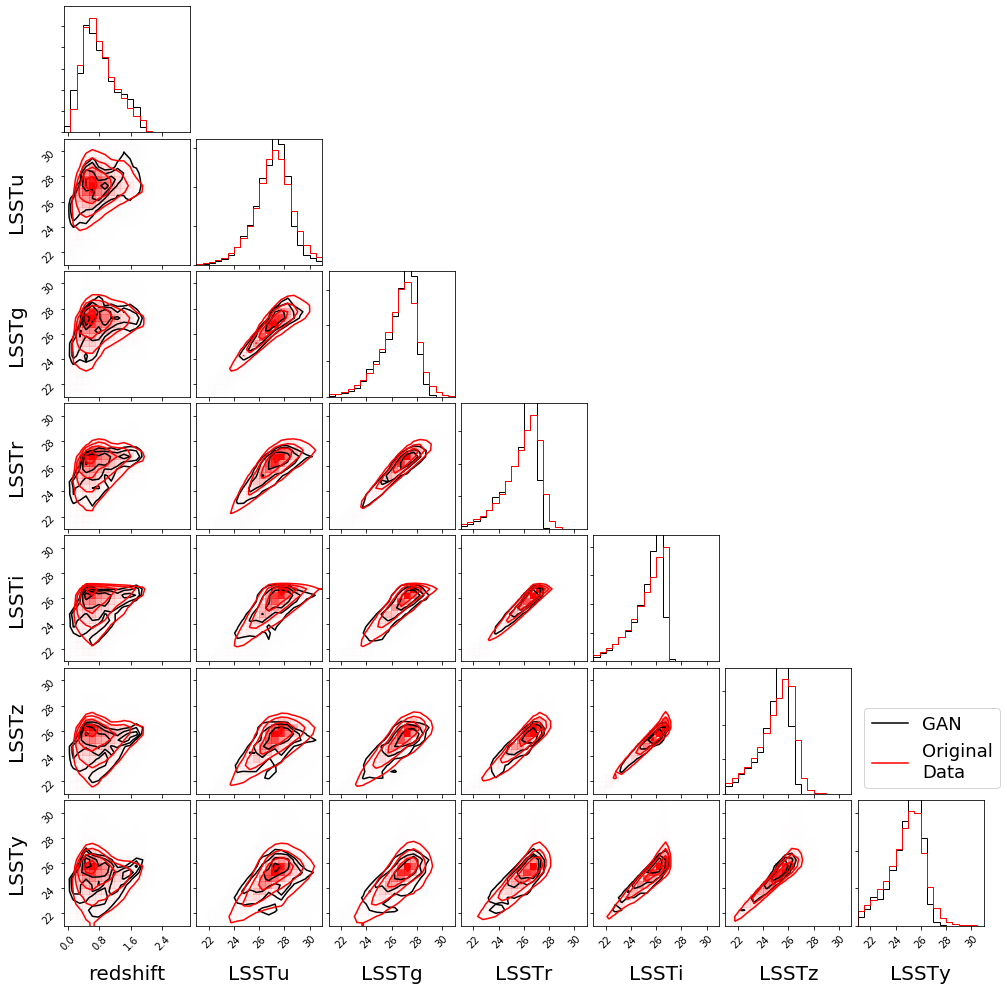

In [38]:
import matplotlib.lines as mlines

limits = [(21, 31)]*6
limits.insert(0, [-0.1, 3.1])
labels = ['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy']
fig, axes = plt.subplots(7, 7, figsize=(14, 14))
corner.corner(new_cat_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy']], 
              range=limits, labels=labels, fig=fig, label_kwargs={'size':20}, 
              plot_datapoints=False, hist_kwargs={'density':True})
corner.corner(train_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy']],
              color='r', plot_datapoints=False, fig=fig, range=limits, labels=labels,
              hist_kwargs={'density':True})

black_line = mlines.Line2D([], [], color='k', label='GAN')
red_line = mlines.Line2D([], [], color='r', label='Original\nData')

plt.legend(handles=[black_line,red_line],
           bbox_to_anchor=(0.2, 1.8, 1., .0), 
           loc=1, fontsize=18)

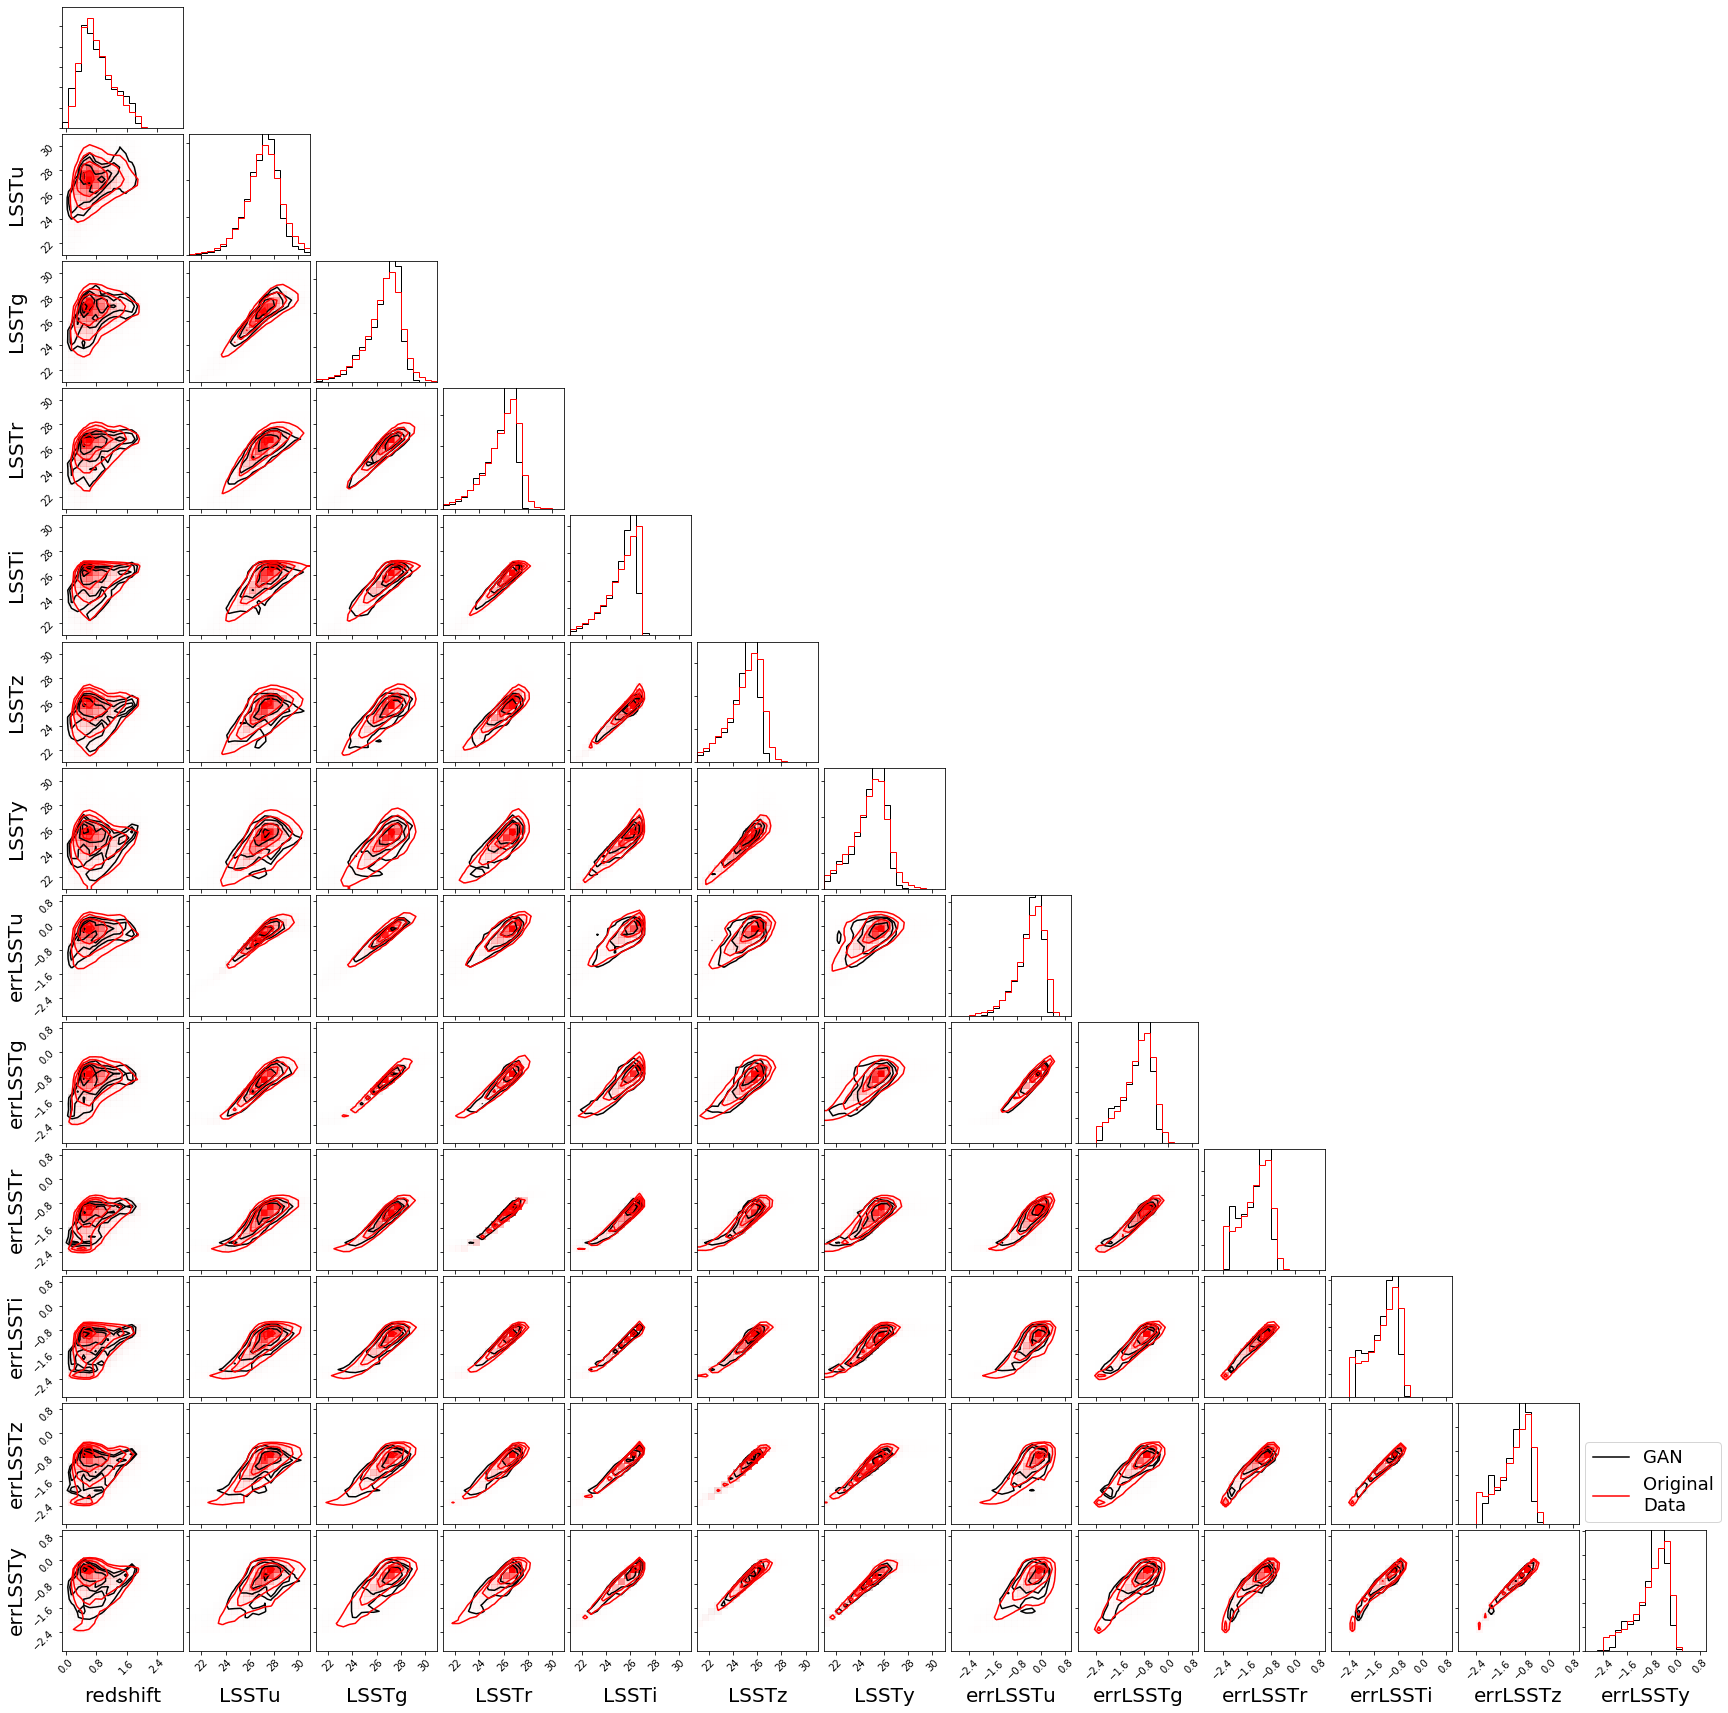

In [41]:
limits = [(21, 31)]*6
for i in range(6):
    limits.append([-3., 1.])
limits.insert(0, [-0.1, 3.1])
labels = ['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']
fig, axes = plt.subplots(13, 13, figsize=(24, 24))
corner.corner(new_cat_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']], 
              range=limits, labels=labels, fig=fig, label_kwargs={'size':20}, 
              plot_datapoints=False, hist_kwargs={'density':True})
corner.corner(train_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']],
              color='r', plot_datapoints=False, fig=fig, range=limits, labels=labels,
              hist_kwargs={'density':True})

black_line = mlines.Line2D([], [], color='k', label='GAN')
red_line = mlines.Line2D([], [], color='r', label='Original\nData')

plt.legend(handles=[black_line,red_line],
           bbox_to_anchor=(0.2, 1.8, 1., .0), 
           loc=1, fontsize=18)

In [45]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    new_cat_df['errLSST%s' % band] = np.power(10, new_cat_df['errLSST%s' % band])

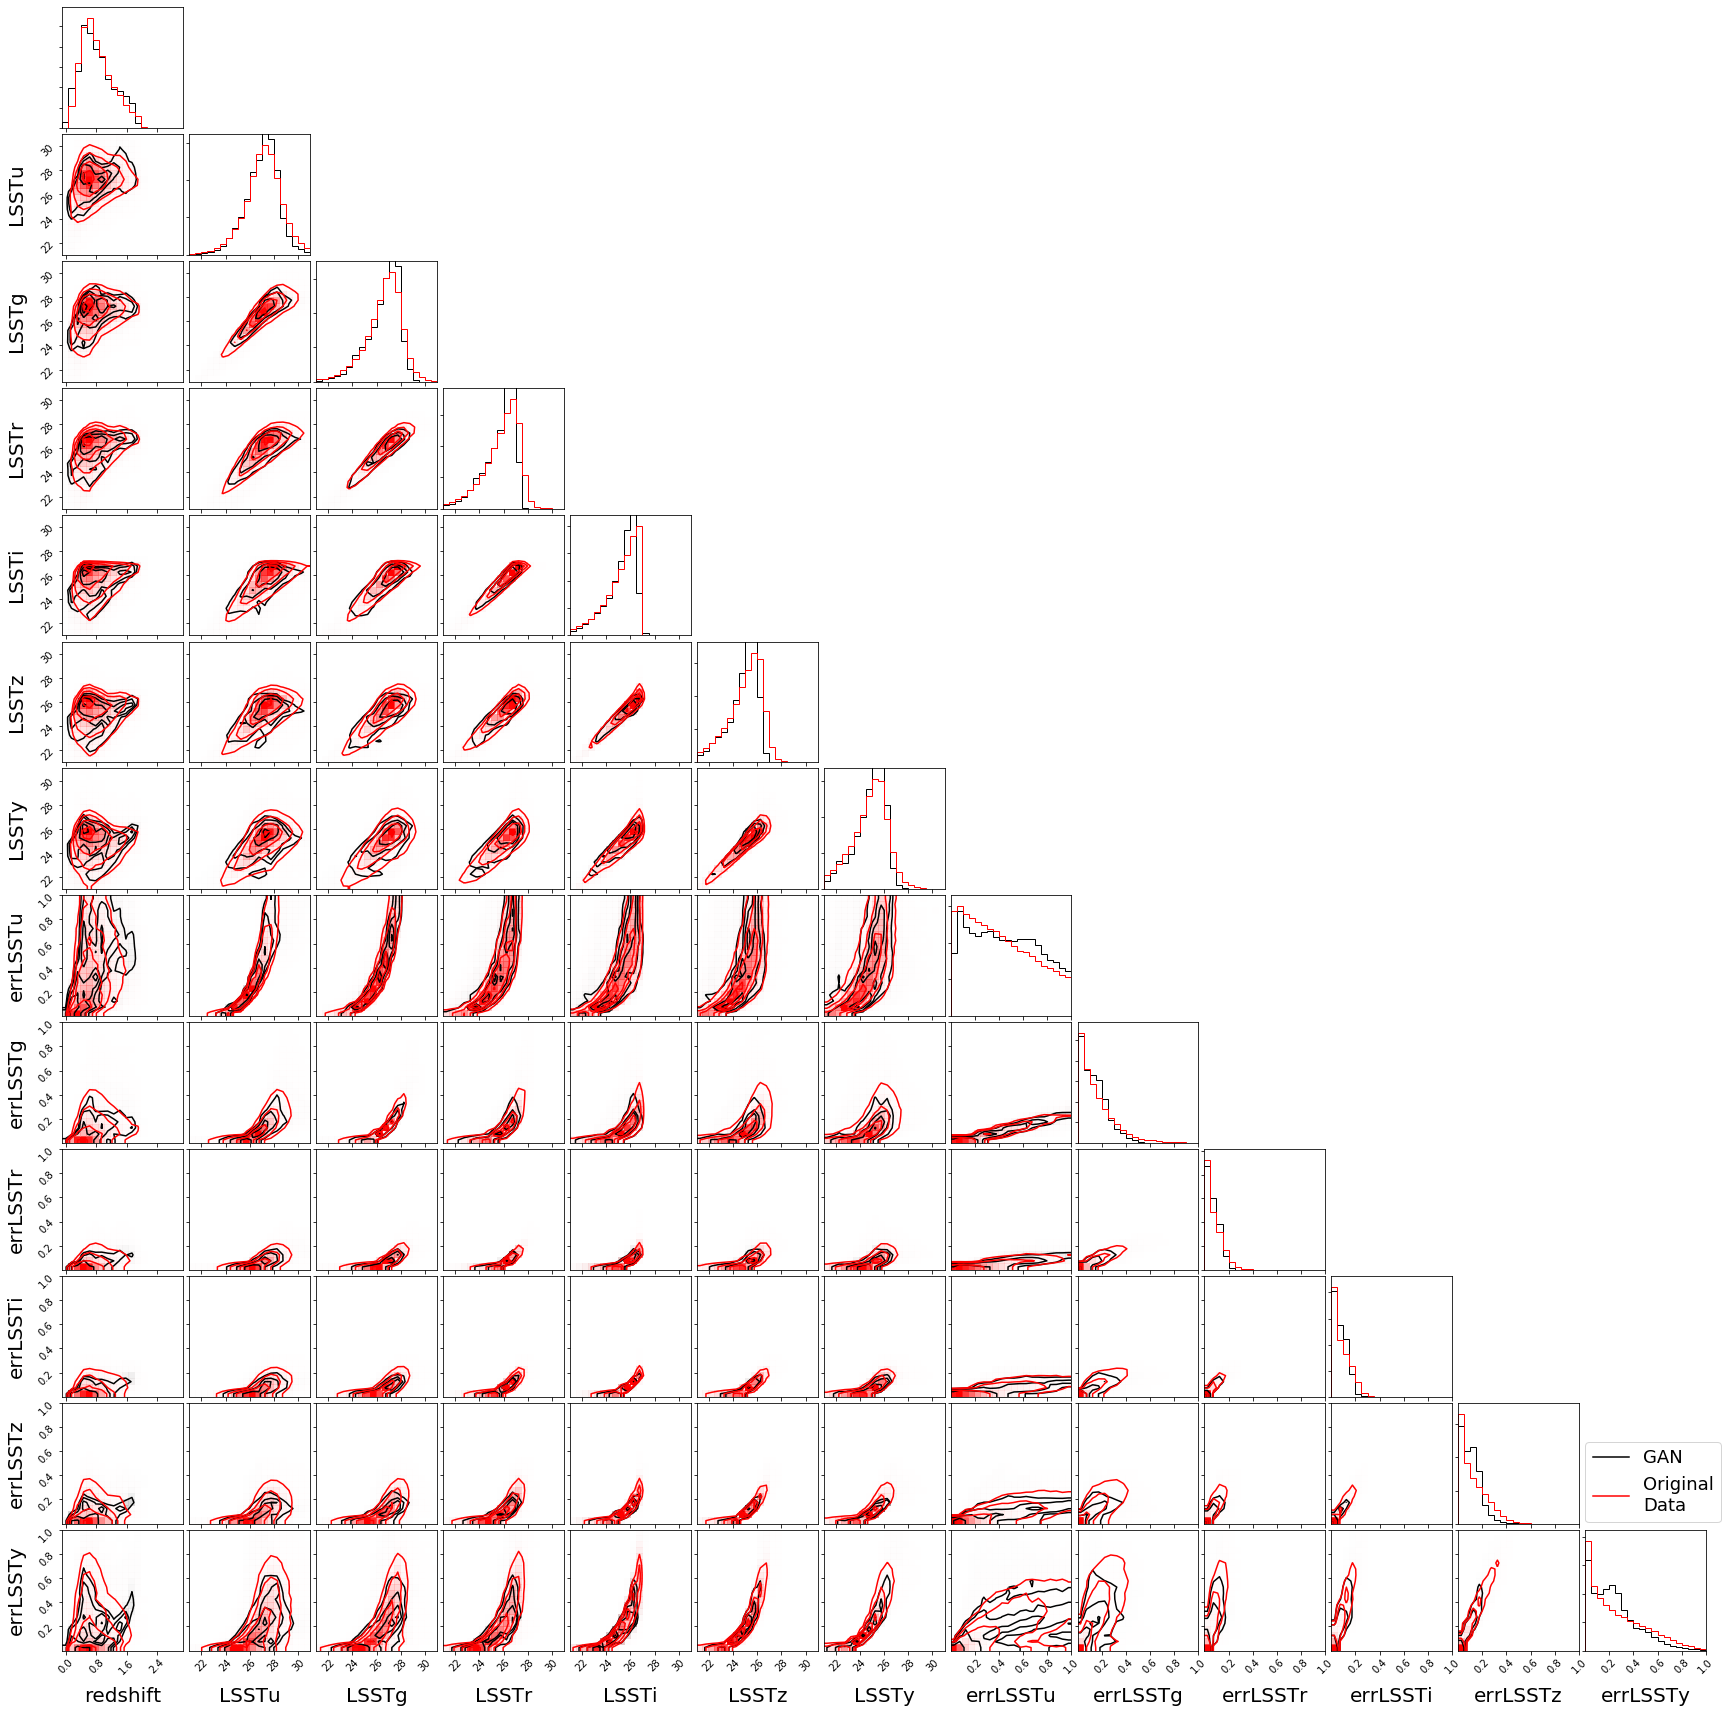

In [46]:
limits = [(21, 31)]*6
for i in range(6):
    limits.append([0, 1.])
limits.insert(0, [-0.1, 3.1])
labels = ['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']
fig, axes = plt.subplots(13, 13, figsize=(24, 24))
new_cat_df
corner.corner(new_cat_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']], 
              range=limits, labels=labels, fig=fig, label_kwargs={'size':20}, 
              plot_datapoints=False, hist_kwargs={'density':True})
corner.corner(clean_data_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']],
              color='r', plot_datapoints=False, fig=fig, range=limits, labels=labels,
              hist_kwargs={'density':True})

black_line = mlines.Line2D([], [], color='k', label='GAN')
red_line = mlines.Line2D([], [], color='r', label='Original\nData')

plt.legend(handles=[black_line,red_line],
           bbox_to_anchor=(0.2, 1.8, 1., .0), 
           loc=1, fontsize=18)

Save Model

In [42]:
### Save model where errors are trained with actual values
#pz_gan.save_model('rail_gan.model')

In [ ]:
### Save model where errors are trained with log10 values
#pz_gan.save_model('rail_gan_logerr.model')